In [0]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import spacy
from nltk import FreqDist
from collections import OrderedDict
import math 

# Import libraries
from sklearn import datasets
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import BaggingClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from xgboost import XGBClassifier

# Load Dataset

In [0]:
# Provided Data

df_train_AAPL = pd.read_csv('../../Predictions/Metalearner/meta_aapl_train.csv') 
df_test_AAPL = pd.read_csv('../../Predictions/Metalearner/meta_aapl_test.csv') 


X_train_AAPL = df_train_AAPL.copy()
y_train_AAPL = df_train_AAPL.copy()
X_test_AAPL = df_test_AAPL.copy()
y_test_AAPL = df_test_AAPL.copy()

In [178]:

print('X_train_AAPL:', X_train_AAPL.shape) # incl Amazon reviews
print('y_train_AAPL:', y_train_AAPL.shape)
print('X_test_AAPL:', X_test_AAPL.shape)
print('y_test_AAPL:', y_test_AAPL.shape)

print()
print("Feature Columns:", X_train_AAPL.columns)

X_train_AAPL: (2013, 19)
y_train_AAPL: (2013, 19)
X_test_AAPL: (503, 19)
y_test_AAPL: (503, 19)

Feature Columns: Index(['Predictions_8k', 'Predictions_10kq', 'Predictions_tweets',
       'Predictions_news', 'Month', 'Day_of_week', 'MACD', 'RSI',
       'Real Middle Band', 'SMA_label', 'Predictions_amxn', 'BB_diff'],
      dtype='object')


# Data Standardization and Preparation
To standardize the technical indicators and get relevant features

1. Create new technical indicators
2. BB difference = Real Upper Band - Real Lower Band
3. Remove Real Upper Band, Real Lower Band, MACD Hist, MACD Signal
4. Shift the technical indicators by 1 
5. Standardize the values


In [0]:
X_train_AAPL["BB_diff"] = X_train_AAPL["Real Upper Band"] - X_train_AAPL["Real Lower Band"]
X_test_AAPL["BB_diff"] = X_test_AAPL["Real Upper Band"] - X_test_AAPL["Real Lower Band"]

X_train_AAPL.drop(columns = ["Real Upper Band", "Real Lower Band", "MACD_Hist", "MACD_Signal"], inplace=True)
X_test_AAPL.drop(columns = ["Real Upper Band", "Real Lower Band", "MACD_Hist", "MACD_Signal"], inplace=True)

In [187]:
df_train_AAPL.head()

,Ticker,Date,Predictions_8k,Predictions_10kq,Predictions_tweets,Predictions_news,Month,Day_of_week,MACD,MACD_Hist,MACD_Signal,RSI,Real Lower Band,Real Middle Band,Real Upper Band,Sector,Label,SMA_label,Predictions_amxn
0,AAPL,2010-01-04,0,0.0,0.0,0.0,1,0,3.9265,1.7781,2.1484,71.2018,193.7786,206.2252,218.6718,Information Technology,1,-1,0
1,AAPL,2010-01-05,0,0.0,0.0,1.0,1,1,4.2876,1.7114,2.5762,71.6362,197.1411,208.1202,219.0993,Information Technology,1,-1,0
2,AAPL,2010-01-06,0,0.0,0.0,-1.0,1,2,4.2496,1.3387,2.9109,62.0505,200.5528,209.3942,218.2356,Information Technology,-1,1,0
3,AAPL,2010-01-07,0,0.0,-1.0,-1.0,1,3,4.1403,0.9835,3.1568,61.0131,203.9426,210.4162,216.8898,Information Technology,-1,-1,0
4,AAPL,2010-01-08,0,0.0,-1.0,-1.0,1,4,4.1192,0.7699,3.3493,63.4505,208.0401,211.4042,214.7683,Information Technology,1,-1,0


In [0]:
from sklearn.preprocessing import StandardScaler
num_cols = ["MACD", "RSI", "Real Middle Band", "SMA_label", "BB_diff"]

for col in num_cols:
    X_train_AAPL[col] = X_train_AAPL[col].shift(1) #Lag Technical Indicators by 1
    X_test_AAPL[col] = X_test_AAPL[col].shift(1)


In [0]:
df_train_AAPL = X_train_AAPL.dropna().reset_index().drop('index', axis=1)
df_test_AAPL = X_test_AAPL.dropna().reset_index().drop('index', axis=1)
X_train_AAPL = df_train_AAPL.drop('Label', axis=1)
y_train_AAPL = df_train_AAPL[['Ticker', 'Date', 'Label']]
X_test_AAPL = df_test_AAPL.drop('Label', axis=1)
y_test_AAPL = df_test_AAPL[['Ticker', 'Date', 'Label']]

In [0]:
from sklearn.preprocessing import StandardScaler
num_cols = ["MACD", "RSI", "BB_diff", "Real Middle Band", "SMA_label"]

for col in num_cols:
    scaler = StandardScaler()
    X_train_AAPL[col] = scaler.fit_transform(X_train_AAPL[[col]])
    X_test_AAPL[col] = scaler.transform(X_test_AAPL[[col]])


In [0]:
combined_AAPL = pd.merge(y_train_AAPL, X_train_AAPL, on=['Ticker', 'Date'])

# EDA

1. Correlation heatmaps and pairwise plots

In [130]:
combined_AAPL.columns

Index(['Ticker', 'Date', 'Label', 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band', 'Sector', 'SMA_label',
       'Predictions_amxn', 'BB_diff'],
      dtype='object')

In [0]:
combined_AAPL_1 = combined_AAPL.reindex([ 'Date', 'Day_of_week', 'Label','Predictions_10kq', 'Predictions_8k', 'Predictions_amxn',
       'Predictions_news', 'Predictions_tweets', 'MACD', 'Month',
        'RSI', 'Real Middle Band','BB_diff',
       'SMA_label', 'Sector', 'Ticker'], axis=1)

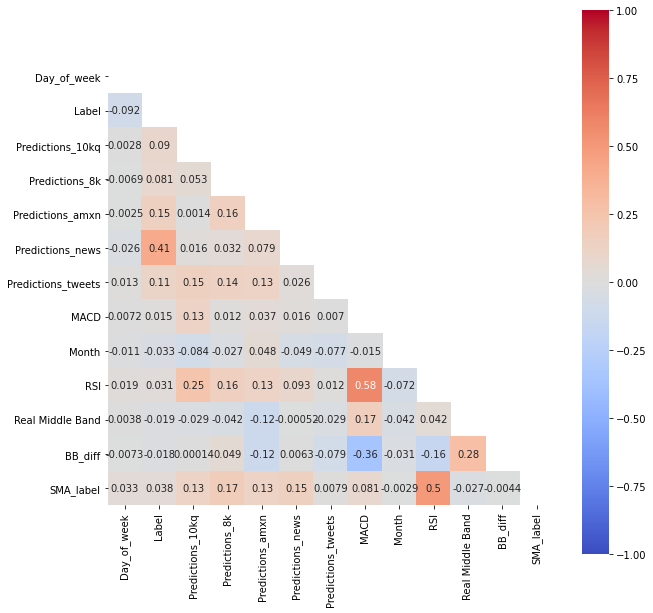

In [132]:
corr = combined_AAPL_1.corr()
fig, ax = plt.subplots(figsize=(10,10))  
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, cmap='coolwarm', mask=mask, annot=True, vmin=-1, vmax=1, center= 0, square=True)

In [49]:
X_train_AAPL.columns

Index(['Ticker', 'Date', 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band', 'Sector', 'SMA_label',
       'Predictions_amxn', 'BB_diff'],
      dtype='object')

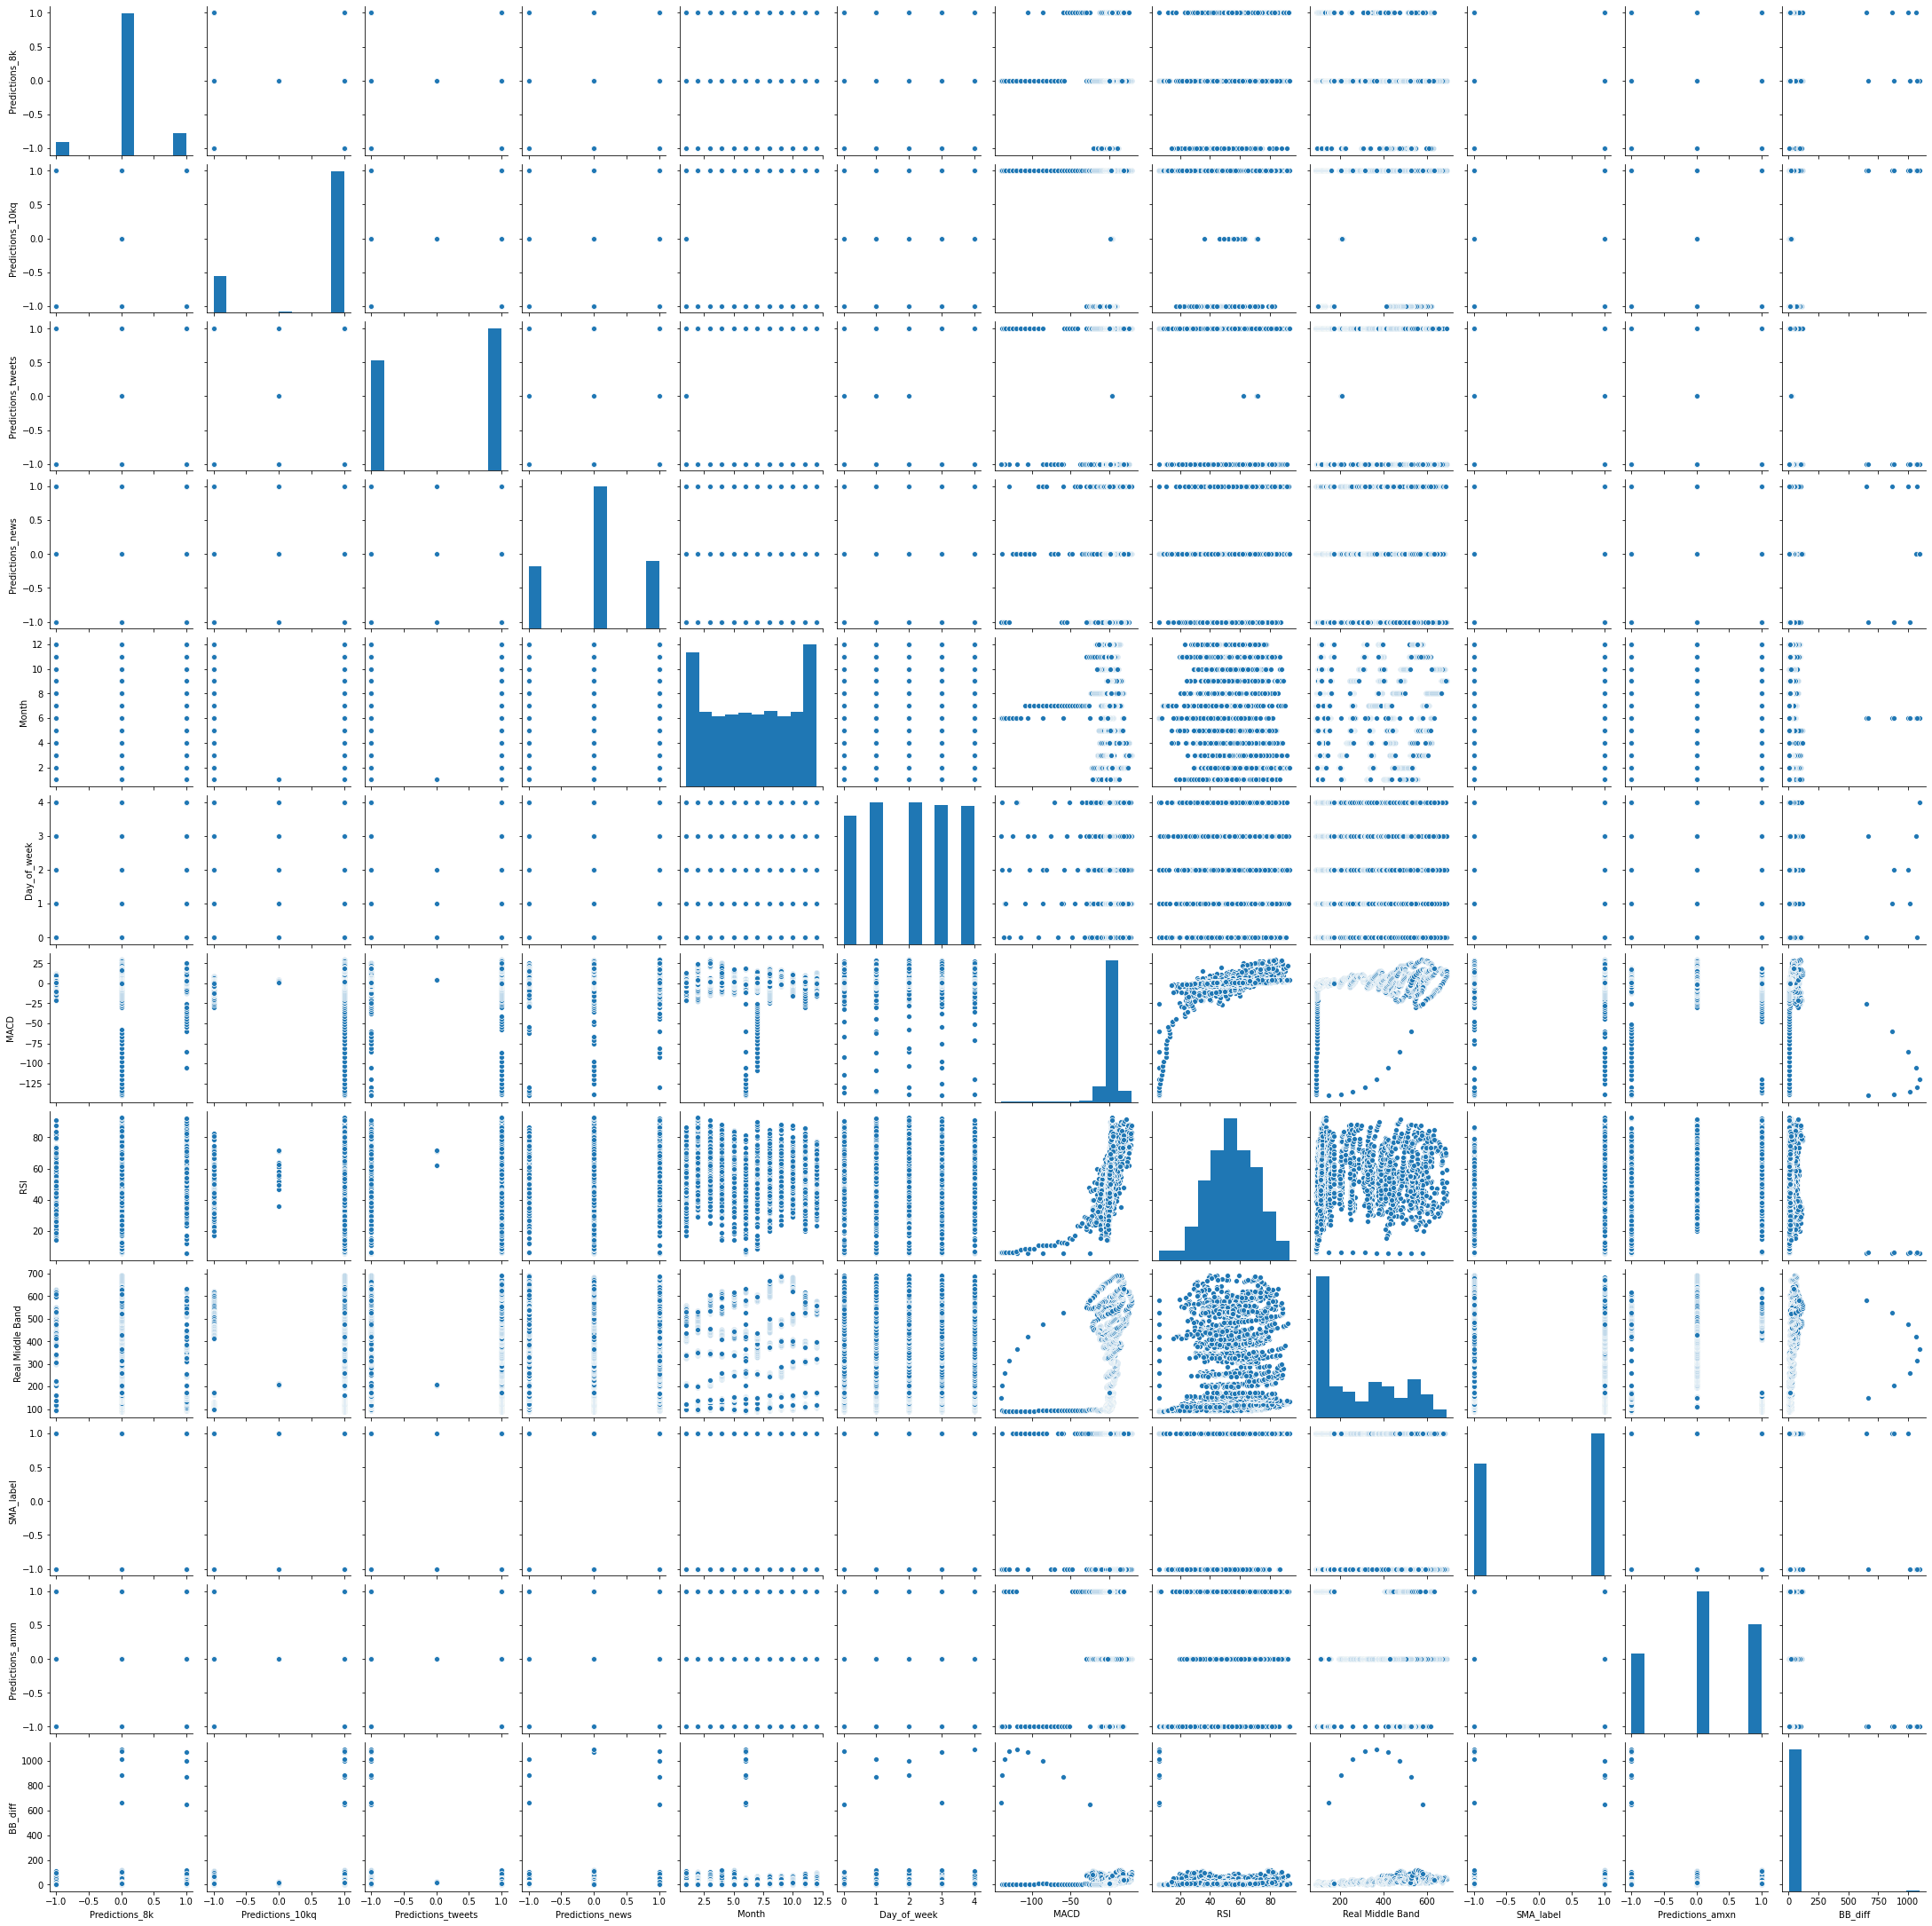

In [0]:
sns.pairplot(X_train_AAPL[['Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band', 'Sector', 'SMA_label',
       'Predictions_amxn', 'BB_diff']])

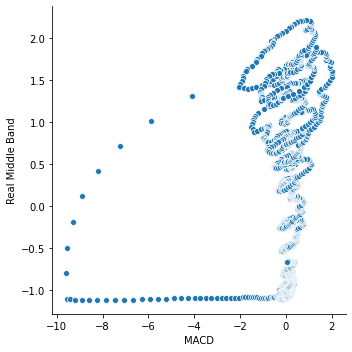

In [0]:
sns.relplot(x="MACD", y="Real Middle Band", data=X_train_AAPL)

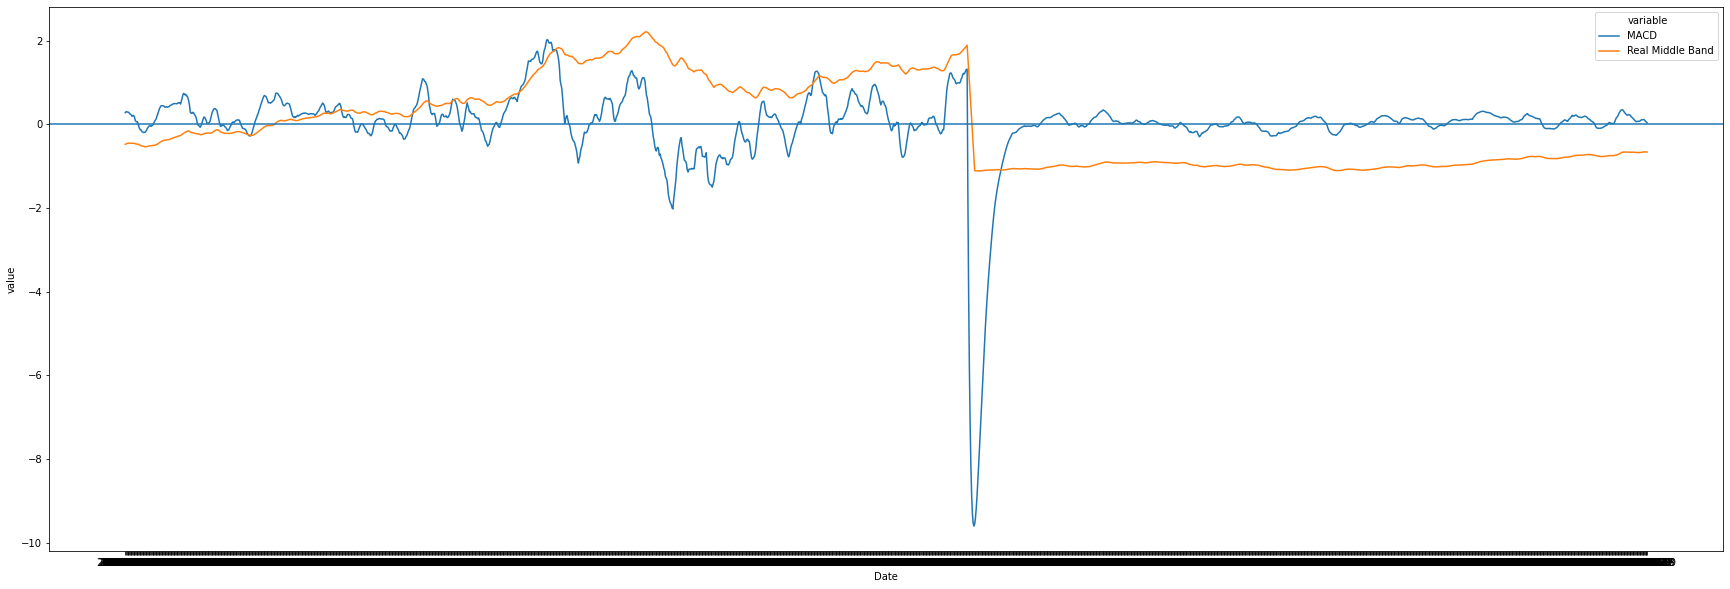

In [0]:
plt.figure(figsize=(30,10))
graph = sns.lineplot(x='Date', y='value', hue='variable', 
             data=pd.melt(X_train_AAPL[['Date','MACD',  'Real Middle Band']], ['Date']))
graph.axhline(0)


# Build 3 different Models to compare Model Performance

1. NLP Model: Only consist of features from the NLP data sources
2. NLP + Technical Indicators Model: Consist both NLP features and the technical indicators
3. NLP + Technical Indicators + Seasonality Model: Consist NLP features, the technical indicators and seasonality

This is to compare how well models will perform with different features

## 1. NLP Model


In [0]:
X_train = X_train_AAPL[[ 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news',  'Predictions_amxn']]
X_test = X_test_AAPL[[ 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news',  'Predictions_amxn']]
y_train = y_train_AAPL['Label']
y_test = y_test_AAPL['Label']

In [135]:
RF_clf =RandomForestClassifier()
RF_clf.fit(X_train, y_train)
RF_pred = RF_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, RF_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))

Training Accuracy:  0.7069051167411823
Test Accuracy:  0.5228628230616302
Accuracy:  0.5228628230616302
Sensitivity:  0.677536231884058
Precision:  0.5532544378698225
ROC AUC Score:  0.5061689969992977


In [136]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)


print('Test Accuracy: ', accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))

Test Accuracy:  0.5248508946322068
Accuracy:  0.5248508946322068
Sensitivity:  0.6123188405797102
Precision:  0.5614617940199336
ROC AUC Score:  0.5154105216114411


In [137]:
LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)
logreg_pred = LogReg_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, LogReg_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))
print("R2 Score: ", r2_score(y_test, logreg_pred))

Training Accuracy:  0.6959761549925484
Test Accuracy:  0.5168986083499006
Sensitivity:  0.6594202898550725
Precision:  0.5498489425981873
ROC AUC Score:  0.5015163123284173
R2 Score:  -0.950919364106493


In [138]:
# Fit Adaboosting Model
AdaBoost_clf = AdaBoostClassifier()
AdaBoost_clf.fit(X_train, y_train)
AdaBoost_clf.classes_
# Validation
AdaBoost_pred = AdaBoost_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, AdaBoost_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, AdaBoost_pred))
print ("Accuracy: ", accuracy_score(y_test,AdaBoost_pred))
print ("Sensitivity: ", recall_score(y_test, AdaBoost_pred))
print ("Precision: ", precision_score(y_test, AdaBoost_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, AdaBoost_pred))
#print(precision_recall_fscore_support(y_test,AdaBoost_pred, average='weighted'))

Training Accuracy:  0.6915052160953801
Test Accuracy:  0.5208747514910537
Accuracy:  0.5208747514910537
Sensitivity:  0.7862318840579711
Precision:  0.543859649122807
ROC AUC Score:  0.4922348847602631


In [0]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                                Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except:
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.plot('xlabel', data=feat_imp)
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp


'BaggingClassifier' object has no attribute 'feature_importances_'
'LogisticRegression' object has no attribute 'feature_importances_'


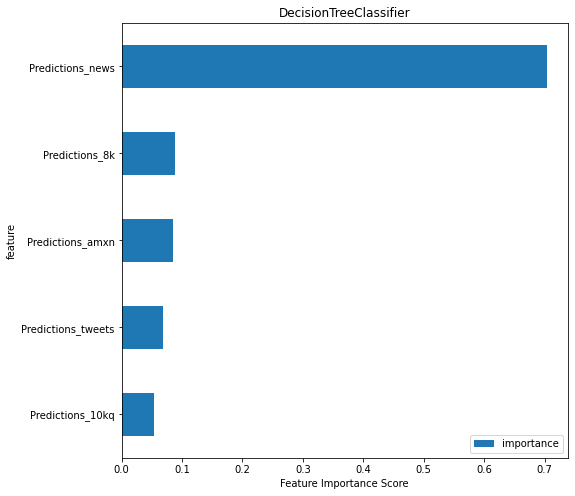

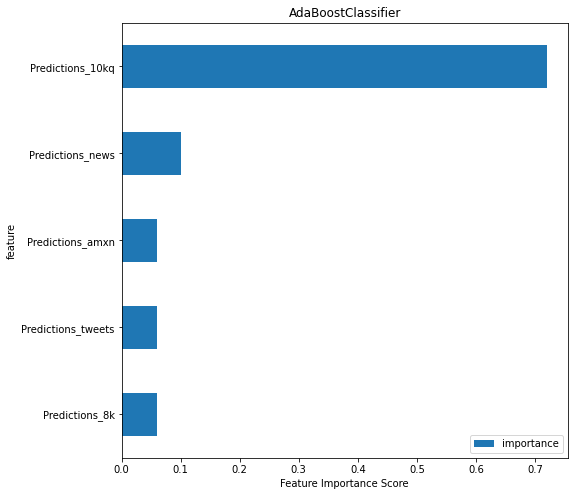

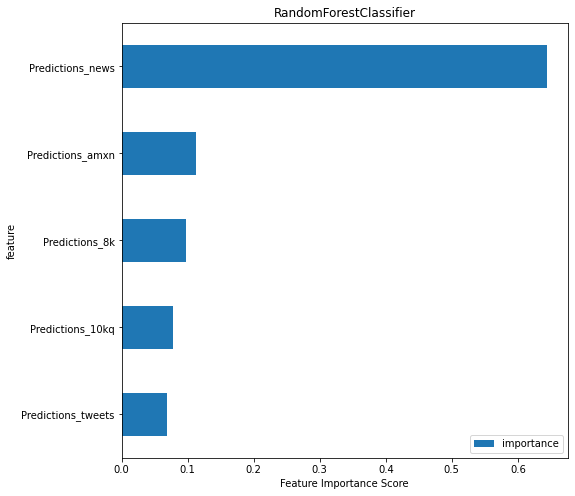

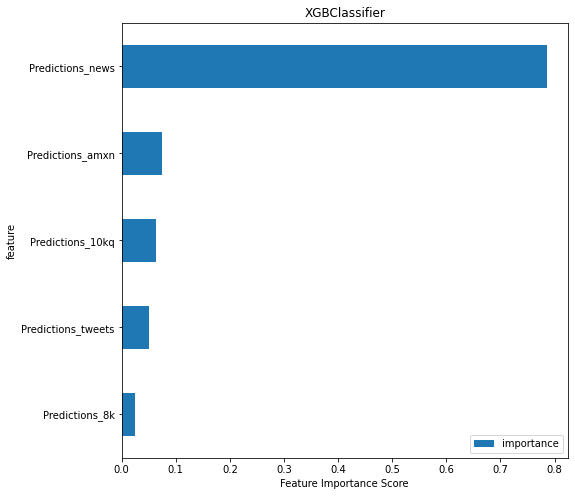

In [140]:
clfs = [BaggingClassifier(),          DecisionTreeClassifier(), LogisticRegression(),
        AdaBoostClassifier(),         RandomForestClassifier(), XGBClassifier()]

for clf in clfs:
    try:
        _ = plot_feature_importances(clf, X_train, y_train, top_n=X_train.shape[1], title=clf.__class__.__name__)
    except AttributeError as e:
        print(e)

## 2. NLP + Technical Indicators Model

In [141]:
X_train_AAPL.columns

Index(['Ticker', 'Date', 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band', 'Sector', 'SMA_label',
       'Predictions_amxn', 'BB_diff'],
      dtype='object')

In [0]:
X_train = X_train_AAPL[[ 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 
       'MACD', 'RSI', 'Real Middle Band',  'SMA_label',
       'Predictions_amxn', 'BB_diff']]
X_test = X_test_AAPL[['Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 
       'MACD', 'RSI', 'Real Middle Band', 'SMA_label',
       'Predictions_amxn', 'BB_diff']]
y_train = y_train_AAPL['Label']
y_test = y_test_AAPL['Label']

In [192]:
RF_clf = RandomForestClassifier(max_depth = 15)
RF_clf.fit(X_train, y_train)
RF_pred = RF_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, RF_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))

Training Accuracy:  0.989065606361829
Test Accuracy:  0.5338645418326693
Accuracy:  0.5338645418326693
Sensitivity:  0.7018181818181818
Precision:  0.5594202898550724
ROC AUC Score:  0.5161073287945535


In [193]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)


print('Test Accuracy: ', accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))

Test Accuracy:  0.5119521912350598
Accuracy:  0.5119521912350598
Sensitivity:  0.7054545454545454
Precision:  0.5418994413407822
ROC AUC Score:  0.4914937925510613


In [194]:
LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)
logreg_pred = LogReg_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, LogReg_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))
print("R2 Score: ", r2_score(y_test, logreg_pred))

Training Accuracy:  0.6958250497017893
Test Accuracy:  0.5318725099601593
Sensitivity:  0.7127272727272728
Precision:  0.5568181818181818
ROC AUC Score:  0.5127513015618743
R2 Score:  -0.8897877452943532


In [195]:
# Fit Adaboosting Model
AdaBoost_clf = AdaBoostClassifier()
AdaBoost_clf.fit(X_train, y_train)
AdaBoost_clf.classes_
# Validation
AdaBoost_pred = AdaBoost_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, AdaBoost_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, AdaBoost_pred))
print ("Accuracy: ", accuracy_score(y_test,AdaBoost_pred))
print ("Sensitivity: ", recall_score(y_test, AdaBoost_pred))
print ("Precision: ", precision_score(y_test, AdaBoost_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, AdaBoost_pred))
#print(precision_recall_fscore_support(y_test,AdaBoost_pred, average='weighted'))

Training Accuracy:  0.7127236580516899
Test Accuracy:  0.5219123505976095
Accuracy:  0.5219123505976095
Sensitivity:  0.7054545454545454
Precision:  0.5495750708215298
ROC AUC Score:  0.5025070084100921


'BaggingClassifier' object has no attribute 'feature_importances_'
'LogisticRegression' object has no attribute 'feature_importances_'


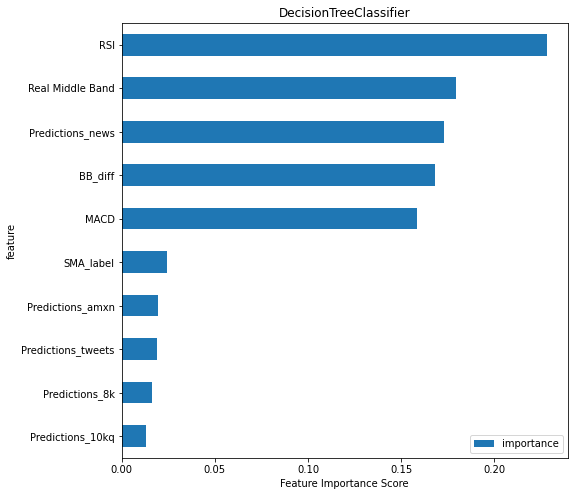

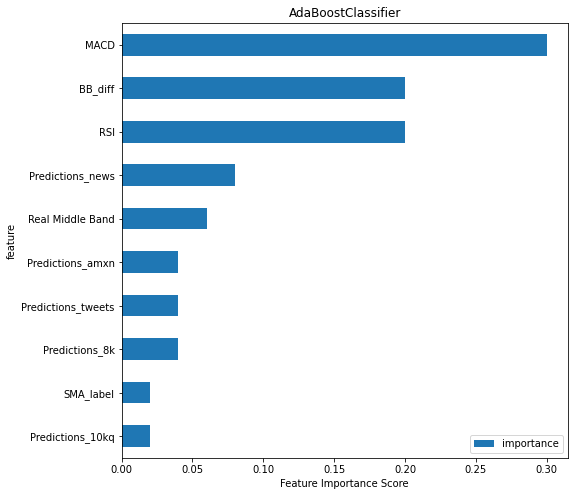

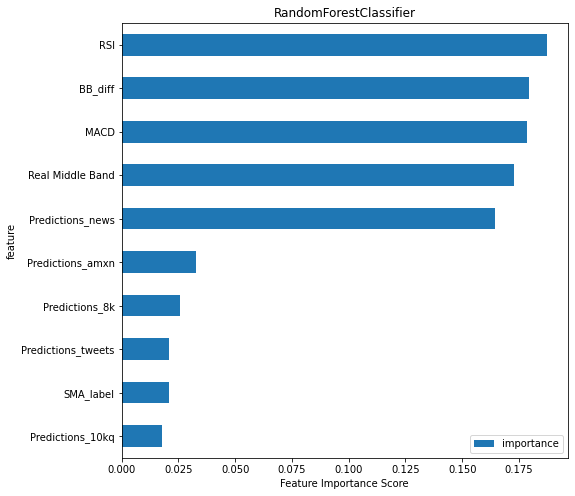

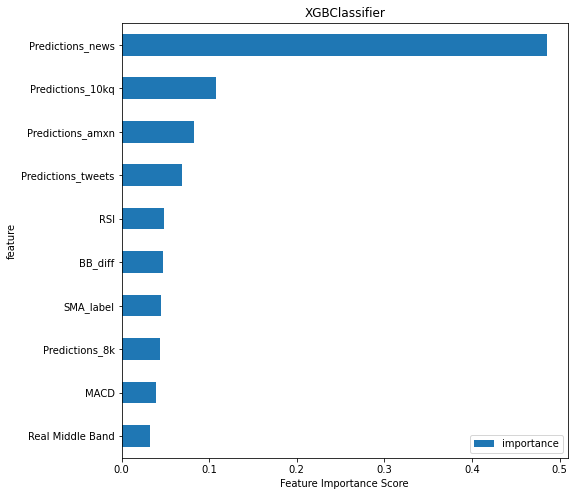

In [196]:
clfs = [BaggingClassifier(),          DecisionTreeClassifier(), LogisticRegression(),
        AdaBoostClassifier(),         RandomForestClassifier(), XGBClassifier()]

for clf in clfs:
    try:
        _ = plot_feature_importances(clf, X_train, y_train, top_n=X_train.shape[1], title=clf.__class__.__name__)
    except AttributeError as e:
        print(e)


## 3. NLP + Technical Indicators + Seasonality Model

In [165]:
X_train_AAPL.columns

Index(['Ticker', 'Date', 'Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band', 'Sector', 'SMA_label',
       'Predictions_amxn', 'BB_diff'],
      dtype='object')

In [0]:
X_train = X_train_AAPL[['Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band',  'SMA_label',
       'Predictions_amxn', 'BB_diff']]
X_test = X_test_AAPL[['Predictions_8k', 'Predictions_10kq',
       'Predictions_tweets', 'Predictions_news', 'Month', 'Day_of_week',
       'MACD', 'RSI', 'Real Middle Band',  'SMA_label',
       'Predictions_amxn', 'BB_diff']]
y_train = y_train_AAPL['Label']
y_test = y_test_AAPL['Label']

In [198]:
RF_clf =RandomForestClassifier(max_depth = 15)
RF_clf.fit(X_train, y_train)
RF_pred = RF_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, RF_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))

Training Accuracy:  0.9995029821073559
Test Accuracy:  0.5597609561752988
Accuracy:  0.5597609561752988
Sensitivity:  0.7381818181818182
Precision:  0.5767045454545454
ROC AUC Score:  0.5408970764917902


In [199]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)


print('Test Accuracy: ', accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))

Test Accuracy:  0.5179282868525896
Accuracy:  0.5179282868525896
Sensitivity:  0.6981818181818182
Precision:  0.5470085470085471
ROC AUC Score:  0.49887064477372856


In [200]:
LogReg_clf = LogisticRegression()
LogReg_clf.fit(X_train, y_train)
logreg_pred = LogReg_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, LogReg_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))
print("R2 Score: ", r2_score(y_test, logreg_pred))

Training Accuracy:  0.6973161033797217
Test Accuracy:  0.5278884462151394
Sensitivity:  0.6836363636363636
Precision:  0.5562130177514792
ROC AUC Score:  0.5114217060472567
R2 Score:  -0.9058710452543051


In [201]:
X_train.columns

Index(['Predictions_8k', 'Predictions_10kq', 'Predictions_tweets',
       'Predictions_news', 'Month', 'Day_of_week', 'MACD', 'RSI',
       'Real Middle Band', 'SMA_label', 'Predictions_amxn', 'BB_diff'],
      dtype='object')

[[ 0.14047949  0.20825534  0.17170554  0.9834055  -0.02852993 -0.19277036
   0.03468691 -0.1107484   0.00984285 -0.08705757  0.26703118 -0.04587224]]


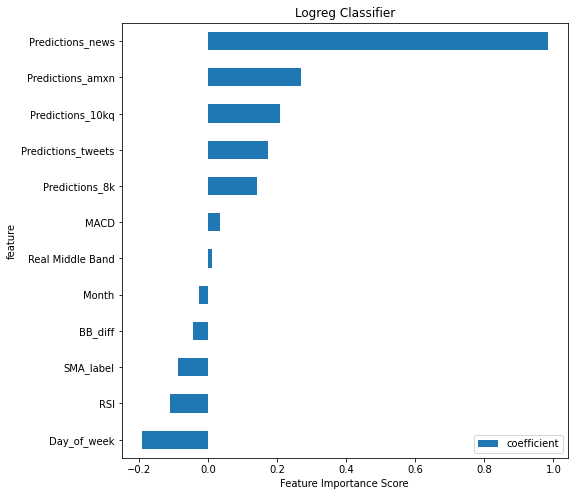

In [243]:

#Standardize X values and get the coefficients of Log Reg model
LogReg_clf.fit(X_train / np.std(X_train, 0), y_train)
print(LogReg_clf.coef_)

lr_feature_importance = pd.concat([pd.DataFrame(X_train.columns, columns=["feature"]),pd.DataFrame(np.transpose(LogReg_clf.coef_), columns=["coefficient"])], axis = 1)
lr_feature_importance.sort_values(by="coefficient", inplace=True, ascending=True)
lr_feature_importance.reset_index(inplace=True, drop=True)

lr_feature_importance = lr_feature_importance.set_index('feature', drop=True)
lr_feature_importance.plot.barh(title="Logreg Classifier", figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.plot('xlabel', data=lr_feature_importance)

In [241]:
abs(LogReg_clf.coef_)

array([[0.14047949, 0.20825534, 0.17170554, 0.9834055 , 0.02852993,
        0.19277036, 0.03468691, 0.1107484 , 0.00984285, 0.08705757,
        0.26703118, 0.04587224]])

For Logistic Regression: We will look into the features importances by fitting the model with standardized values and get the absolute coefficients to determine the importance of the features.


1. Predictions_news = 0.798
2. RSI = 0.530
3. SMA_label = 0.449
4. MACD = -0.327
5. Predictions_tweets = 0.199
6. Day_of_week = -0.189
7. Predictions_amxn = 0.124
8. BB_diff = -0.0648
9. Predictions_8k = -0.0433
10. Predictions_10kq = 0.0381
11. Real Middle Band = 0.0364
12. Month = -0.0087

In [203]:
## Fit Adaboosting Model
AdaBoost_clf = AdaBoostClassifier()
AdaBoost_clf.fit(X_train, y_train)
AdaBoost_clf.classes_
# Validation
AdaBoost_pred = AdaBoost_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, AdaBoost_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, AdaBoost_pred))
print ("Accuracy: ", accuracy_score(y_test,AdaBoost_pred))
print ("Sensitivity: ", recall_score(y_test, AdaBoost_pred))
print ("Precision: ", precision_score(y_test, AdaBoost_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, AdaBoost_pred))
#print(precision_recall_fscore_support(y_test,AdaBoost_pred, average='weighted'))

Training Accuracy:  0.7137176938369781
Test Accuracy:  0.5239043824701195
Accuracy:  0.5239043824701195
Sensitivity:  0.7090909090909091
Precision:  0.5508474576271186
ROC AUC Score:  0.5043251902282739


'BaggingClassifier' object has no attribute 'feature_importances_'
'LogisticRegression' object has no attribute 'feature_importances_'


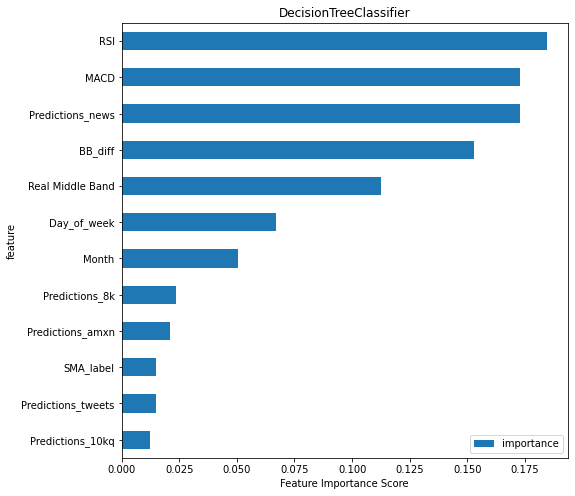

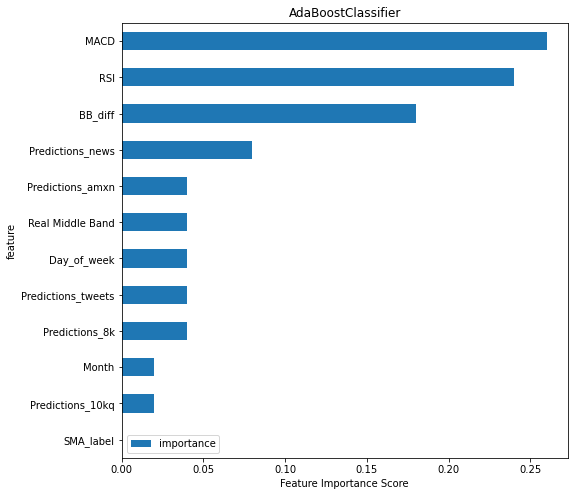

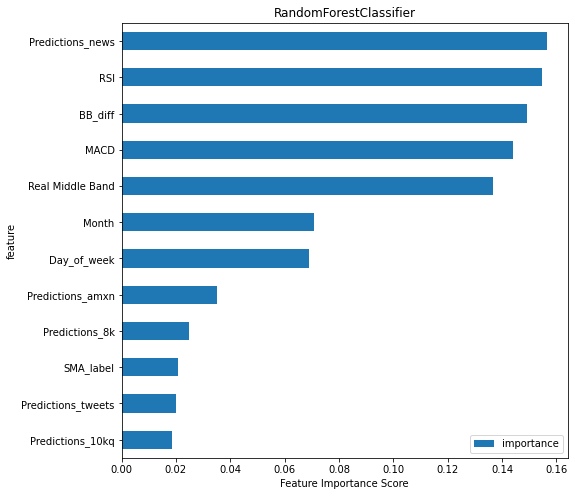

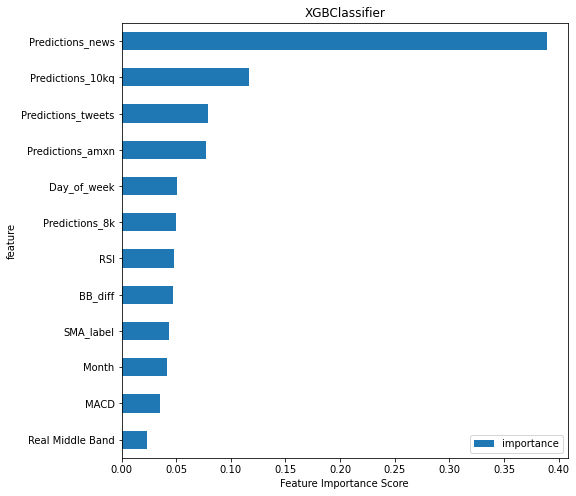

In [204]:
clfs = [BaggingClassifier(),          DecisionTreeClassifier(), LogisticRegression(),
        AdaBoostClassifier(),         RandomForestClassifier(), XGBClassifier()]

for clf in clfs:
    try:
        _ = plot_feature_importances(clf, X_train, y_train, top_n=X_train.shape[1], title=clf.__class__.__name__)
    except AttributeError as e:
        print(e)



## Tuning the Models

##### Fine tune the hyperparameters for Random Forest, Logistic Regression and XGBoost 

### Tune Random Forest

In [0]:
from sklearn.model_selection import GridSearchCV

rf_params = {"n_estimators": [50, 100], "criterion": ["gini", "entropy"], "max_depth": [10, 20], "max_features": ["sqrt", "log2"]}
rf =RandomForestClassifier(random_state=111)

In [206]:
rf_clf = GridSearchCV(rf, rf_params)
rf_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=111,
                              

In [207]:
rf_clf.best_score_

0.6669703591225016

In [208]:
rf_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [209]:
sorted(rf_clf.cv_results_.keys())


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [216]:
rf_clf = RandomForestClassifier(random_state=111, criterion="entropy", max_depth=10, max_features = "sqrt", n_estimators=500)
rf_clf.fit(X_train, y_train)
RF_pred = rf_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, rf_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, RF_pred))
print ("Accuracy: ", accuracy_score(y_test,RF_pred))
print ("Sensitivity: ", recall_score(y_test, RF_pred))
print ("Precision: ", precision_score(y_test, RF_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, RF_pred))
print("F1 Score: ", f1_score(y_test, RF_pred))

Training Accuracy:  0.8812127236580517
Test Accuracy:  0.5258964143426295
Accuracy:  0.5258964143426295
Sensitivity:  0.7381818181818182
Precision:  0.5501355013550135
ROC AUC Score:  0.5034521425710853
F1 Score:  0.6304347826086956


### Tune LogReg

In [0]:
logreg_params = {"penalty": ["l1", 'l2'], "fit_intercept": [True, False], "solver": ["saga"], "max_iter": [50, 100, 150]}


In [0]:
lr = LogisticRegression(random_state=111)

In [213]:
lr_clf = GridSearchCV(lr, logreg_params)
lr_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=111, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'max_iter': [50, 100, 150], 'penalty': ['l1', 'l2'],
                         'solver': ['saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [214]:
lr_clf.best_score_

0.6938199819759762

In [215]:
lr_clf.best_params_

{'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'solver': 'saga'}

In [217]:
sorted(lr_clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_fit_intercept',
 'param_max_iter',
 'param_penalty',
 'param_solver',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [218]:
lr_clf = LogisticRegression(random_state=111, fit_intercept= False, max_iter=50, penalty="l2", solver="saga")
lr_clf.fit(X_train, y_train)

logreg_pred = lr_clf.predict(X_test)
# Get the training accuracy
print('Training Accuracy: ', accuracy_score(y_train, lr_clf.predict(X_train)))
# print the accuracy of its predictions
print('Test Accuracy: ', accuracy_score(y_test, logreg_pred))
print ("Sensitivity: ", recall_score(y_test, logreg_pred))
print ("Precision: ", precision_score(y_test, logreg_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, logreg_pred))
print("F1 Score: ", f1_score(y_test, logreg_pred))
print("R2 Score: ", r2_score(y_test, logreg_pred))

Training Accuracy:  0.7052683896620279
Test Accuracy:  0.5199203187250996
Sensitivity:  0.6618181818181819
Precision:  0.5515151515151515
ROC AUC Score:  0.5049179014817782
F1 Score:  0.6016528925619834
R2 Score:  -0.938037645174209


### Tune XGB model

In [0]:
xgb_params = {"max_depth": [50, 100], "min_child_weight": [10, 20], "reg_alpha": [0.01, 0.001], "reg_lamba": [0.01, 0.001]}

In [0]:
xgb = XGBClassifier(random_state=111)

In [221]:
xgb_clf = GridSearchCV(xgb, xgb_params)
xgb_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=111, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [50, 100], 'min_child_weight': [10, 20],
                         'reg_alpha': [0.01, 0.001],
   

In [222]:
xgb_clf.best_score_

0.6630038393639742

In [223]:
xgb_clf.best_params_

{'max_depth': 50, 'min_child_weight': 10, 'reg_alpha': 0.01, 'reg_lamba': 0.01}

In [224]:
sorted(xgb_clf.cv_results_.keys()) 

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_min_child_weight',
 'param_reg_alpha',
 'param_reg_lamba',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [228]:
xgb_clf = XGBClassifier(random_state=111, max_depth=50, min_child_weight=10, reg_alpha=0.01, reg_lambda = 0.01)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, xgb_clf.predict(X_train)))
print('Test Accuracy: ', accuracy_score(y_test, xgb_pred))
print ("Accuracy: ", accuracy_score(y_test,xgb_pred))
print ("Sensitivity: ", recall_score(y_test, xgb_pred))
print ("Precision: ", precision_score(y_test, xgb_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, xgb_pred))
print("F1 Score: ", f1_score(y_test, xgb_pred))

Training Accuracy:  0.8981113320079522
Test Accuracy:  0.5298804780876494
Accuracy:  0.5298804780876494
Sensitivity:  0.6763636363636364
Precision:  0.5585585585585585
ROC AUC Score:  0.5143932719263116
F1 Score:  0.6118421052631579


## Ensemble: Combine all 3 models 

In [229]:
vote_avg = xgb_pred + logreg_pred + RF_pred
vote_avg = vote_avg/3
vote_avg

array([-1.        , -1.        , -0.33333333, -0.33333333,  1.        ,
        0.33333333,  1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -0.33333333, -0.33333333,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.33333333,  1.        ,  1.        ,  1.        ,
        1.        ,  0.33333333,  1.        ,  1.        ,  0.33333333,
        1.        ,  0.33333333,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.33333333,
        0.33333333,  0.33333333,  0.33333333,  0.33333333, -1.        ,
       -1.        ,  0.33333333,  0.33333333,  1.        ,  1.        ,
        1.        ,  1.        , -1.        , -1.        , -1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [0]:
ensemble_pred = pd.Series(map(lambda x: 1 if x>0 else -1, vote_avg))

In [231]:
ensemble_pred

0     -1
1     -1
2     -1
3     -1
4      1
      ..
497    1
498   -1
499    1
500   -1
501   -1
Length: 502, dtype: int64

In [232]:
## Check accuracy
print('Test Accuracy: ', accuracy_score(y_test, ensemble_pred))
print ("Accuracy: ", accuracy_score(y_test,ensemble_pred))
print ("Sensitivity: ", recall_score(y_test, ensemble_pred))
print ("Precision: ", precision_score(y_test, ensemble_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, ensemble_pred))
print("F1 Score: ", f1_score(y_test, ensemble_pred))

Test Accuracy:  0.5338645418326693
Accuracy:  0.5338645418326693
Sensitivity:  0.72
Precision:  0.5577464788732395
ROC AUC Score:  0.5141850220264317
F1 Score:  0.6285714285714287


In [0]:
classifier_names = ["RandomForest","LogisticRegression","XGB"]
classifiers = [rf_clf, lr_clf, xgb_clf]
results = dict()
for i,classifier in enumerate(classifiers):
  y_pred = classifier.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test,y_pred)
  metrics =  {"accuracy": acc, "recall_score": recall, "precision": precision, "f1_score":f1}
  results[classifier_names[i]] = metrics


In [0]:
acc

0.6401590457256461

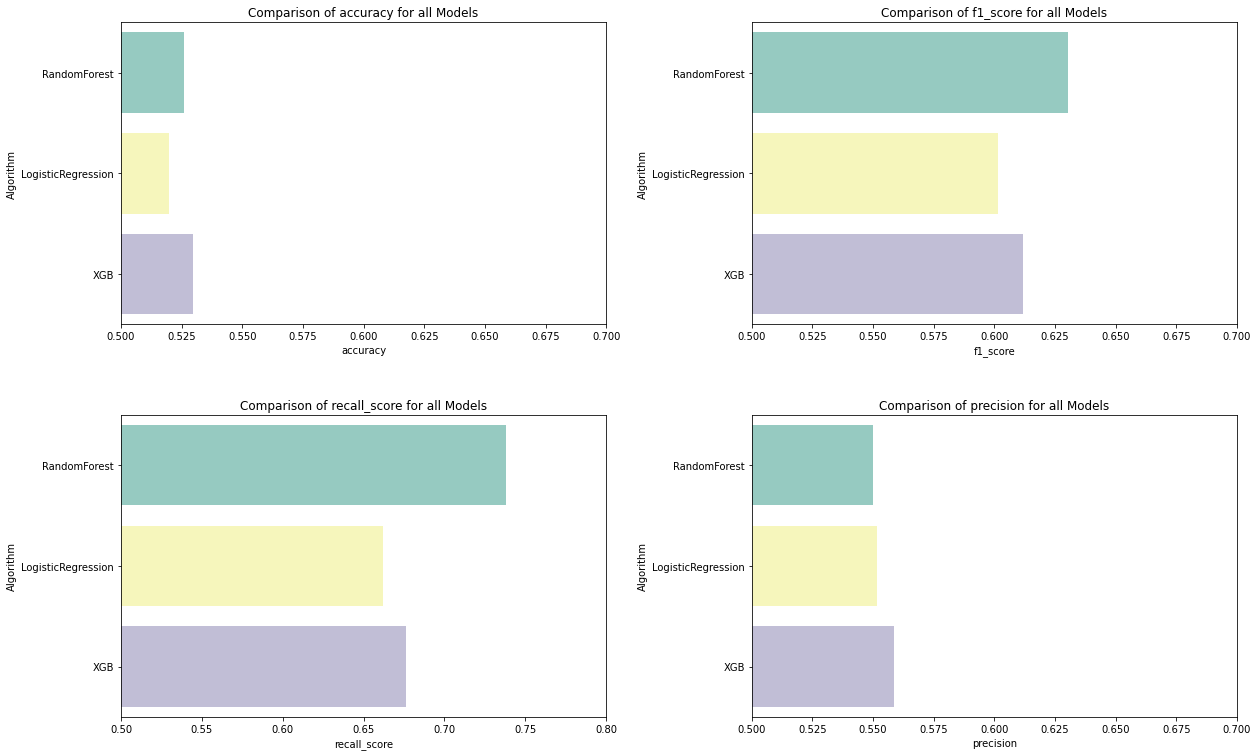

In [244]:
metrics = ["accuracy","f1_score","recall_score","precision"]

model_score_by_metric = []

for i in metrics:
    sub = []
    for j in classifier_names:
        sub.append(results[j][i])
    model_score_by_metric.append(sub)


fig = plt.figure(constrained_layout=False, figsize=(20,20))
spec = fig.add_gridspec(3, 2, wspace=0.3, hspace=0.3)

for i,met in enumerate(metrics):
    #print(met)
    res = pd.DataFrame({"CrossValScore":model_score_by_metric[i],"Algorithm":classifier_names})
    #print(cv_res)
    
    axes = fig.add_subplot(spec[i])

    g = sns.barplot("CrossValScore","Algorithm",data = res, palette="Set3",orient = "h")
    g.set_xlabel(met)
    if met == "accuracy":
        g.set_xlim(0.5, 0.7)
    elif met == "f1_score":
        g.set_xlim(0.5, 0.7)
    elif met == "recall_score":
        g.set_xlim(0.5, 0.8)
    else:
        g.set_xlim(0.5,0.7)
    g = g.set_title(f"Comparison of {met} for all Models")

In [0]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=5, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                                Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except:
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.plot('xlabel', data=feat_imp)
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

'LogisticRegression' object has no attribute 'feature_importances_'


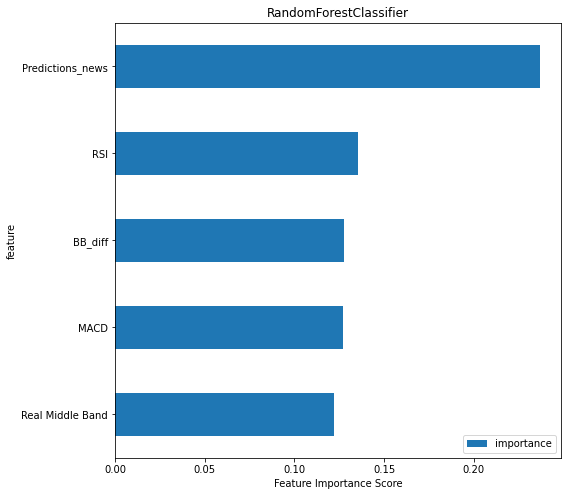

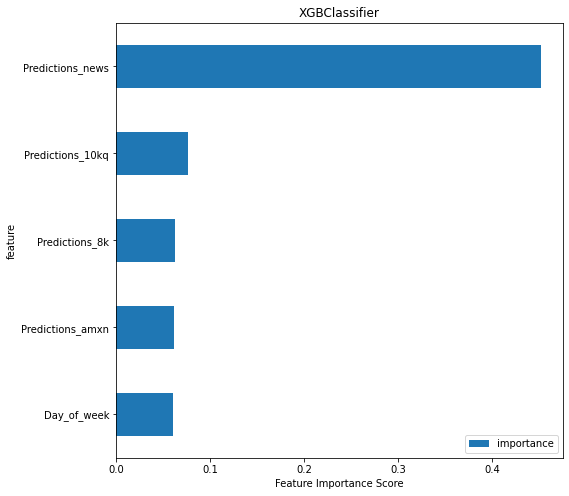

In [236]:
for clf in classifiers:
    try:
        _ = plot_feature_importances(clf, X_train, y_train, top_n=5, title=clf.__class__.__name__)
    except AttributeError as e:
        print(e)

In [0]:
df_test_AAPL["ensemble_pred"] = ensemble_pred
df_test_AAPL["xgb_pred"] = xgb_pred
df_test_AAPL["logreg_pred"] = logreg_pred
df_test_AAPL["RF_pred"] = RF_pred

In [0]:
df_test_AAPL.to_csv("../../Predictions/Metalearner/df_test_AAPL_predictions.csv", index=False)